# Import Libraries and Load Data

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Load the dataset
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Convert 'Date' column to datetime and set it as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Display dataset info
print(data.head())
print(data.dtypes)


                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2010-01-04  17.913334  18.223333  17.889999  18.076668  13.113414  62259300
2010-01-05  18.030001  18.063334  17.856667  17.896667  12.982840  46945200
2010-01-06  17.833332  17.943333  17.806667  17.856667  12.953820  37551600
2010-01-07  17.906668  17.916668  17.753332  17.866667  12.961074  31988100
2010-01-08  17.809999  17.843332  17.673332  17.776667  12.895782  34089600
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


## Visualizing Closing Price Trend

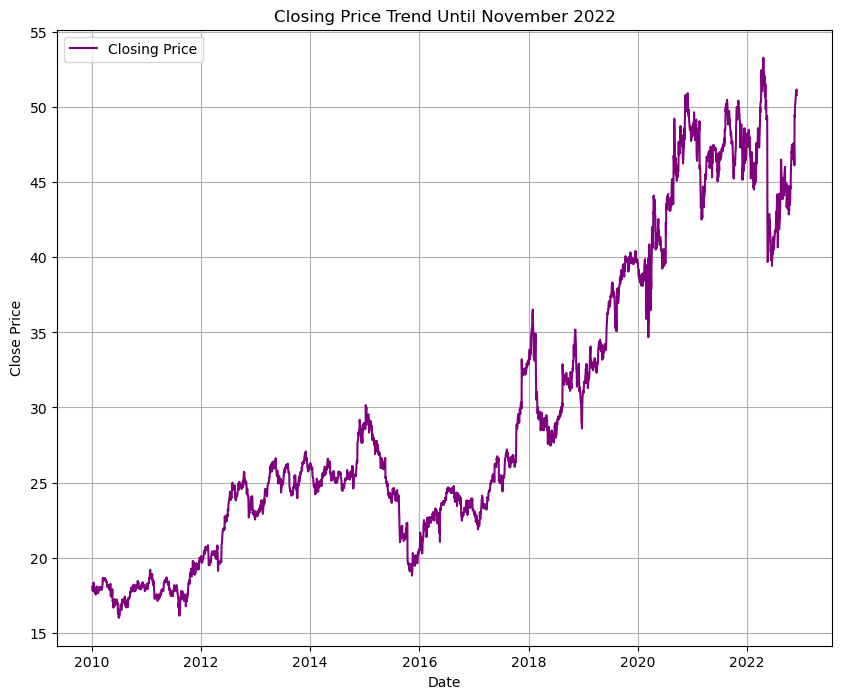

In [50]:
# Filter the data up to "30-11-2022"
filtered_data = data[':'2022-11-30']

# Plot Closing Price Trend
plt.figure(figsize=(10, 8))
plt.plot(filtered_data['Close'], label='Closing Price', color='purple')
plt.title('Closing Price Trend Until November 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Data Preparation for LSTM

In [40]:
# Scaling the Close prices for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Splitting into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]  # Keeping last 60 days for context

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences
seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


## Building & Training LSTM Model

In [41]:
# Build the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(units=50),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test))

# Predict on test data
predicted_scaled = model.predict(X_test)

# Convert scaled predictions back to original values
predicted = scaler.inverse_transform(predicted_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - loss: 0.0132 - val_loss: 0.0019
Epoch 2/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 3.7662e-04 - val_loss: 0.0025
Epoch 3/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 4.1015e-04 - val_loss: 0.0021
Epoch 4/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 3.5459e-04 - val_loss: 0.0015
Epoch 5/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 3.3995e-04 - val_loss: 0.0013
Epoch 6/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 3.0572e-04 - val_loss: 0.0019
Epoch 7/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 3.2210e-04 - val_loss: 0.0013
Epoch 8/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 2.7003e-04 - val_loss: 0.0011
Epoch 9/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 2.9781e-04 - val_loss: 9.5175e-04
Epoch 10/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 2.9091e-04 - val_loss: 9.3767e-04
Epoch 11/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 2.5115e-04 - val_loss: 0.0010
Epoch 12/60
80

## LSTM Predictions Visualization (December 2022)

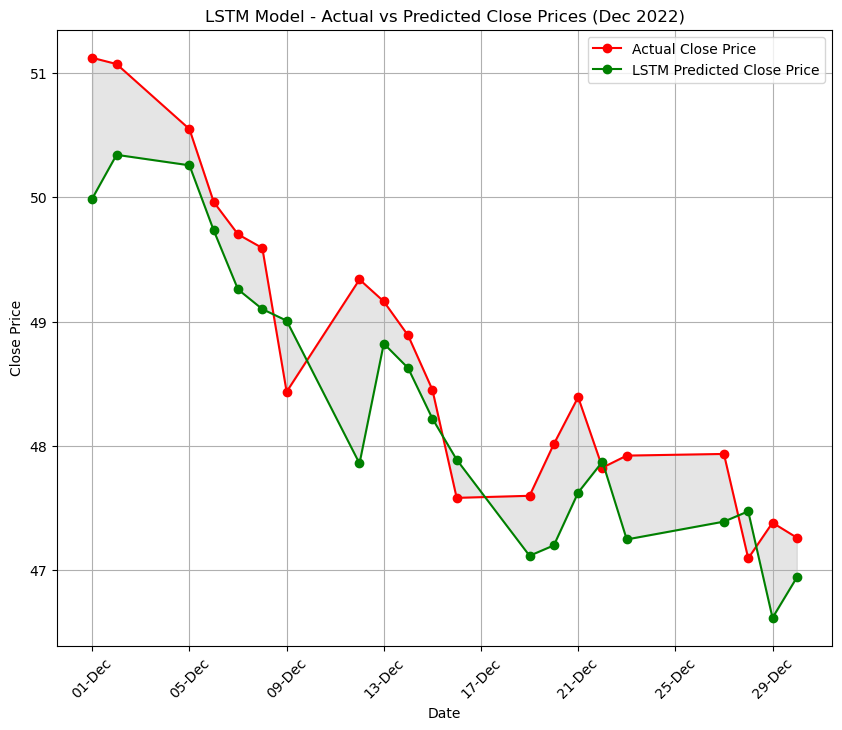

In [42]:
# Filter December 2022 Data
december_start, december_end = '2022-12-01', '2022-12-30'
december_mask = (data.index >= december_start) & (data.index <= december_end)
december_dates = data.index[december_mask]

# Get corresponding LSTM predictions
predicted_december = predicted[-len(december_dates):]
y_test_december = y_test_actual[-len(december_dates):]

# Plot LSTM Predictions for December 2022
plt.figure(figsize=(10, 8))
plt.plot(december_dates, y_test_december, label='Actual Close Price', color='red', marker='o')
plt.plot(december_dates, predicted_december, label='LSTM Predicted Close Price', color='green', marker='o')

plt.title('LSTM Model - Actual vs Predicted Close Prices (Dec 2022)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.fill_between(december_dates, y_test_december.flatten(), predicted_december.flatten(), color='gray', alpha=0.2)
plt.legend()
plt.grid(True)
plt.show()


# ARIMA Model Training & Forecasting

In [43]:
# Fit ARIMA model
arima_model = ARIMA(data['Close'], order=(6, 2, 0))
arima_model_fit = arima_model.fit()

# ARIMA Forecast for December 2022
arima_forecast = arima_model_fit.predict(start=december_start, end=december_end, dynamic=False)


C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## ARIMA Predictions Visualization

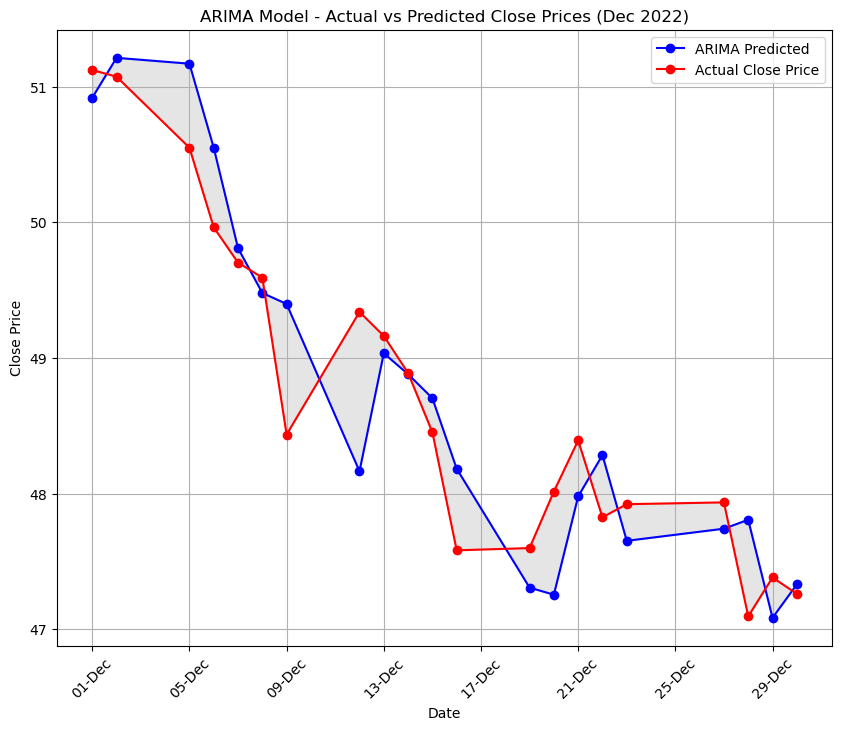

In [44]:
# Plot ARIMA Predictions for December 2022
plt.figure(figsize=(10, 8))
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Predicted', color='blue', marker='o')
plt.plot(december_dates, data['Close'][december_mask], label='Actual Close Price', color='red', marker='o')

plt.title('ARIMA Model - Actual vs Predicted Close Prices (Dec 2022)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.fill_between(arima_forecast.index, data['Close'][december_mask], arima_forecast, color='gray', alpha=0.2)
plt.legend()
plt.grid(True)
plt.show()


# Prophet Model Training & Forecasting

In [45]:
# Prepare data for Prophet
prophet_data = data.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Generate forecasts
future_dates = prophet_model.make_future_dataframe(periods=600)
prophet_forecast = prophet_model.predict(future_dates)

# Extract December 2022 predictions
prophet_predictions = prophet_forecast.set_index('ds').loc[december_start:december_end]


10:26:35 - cmdstanpy - INFO - Chain [1] start processing
10:26:37 - cmdstanpy - INFO - Chain [1] done processing


## Prophet Predictions Visualization

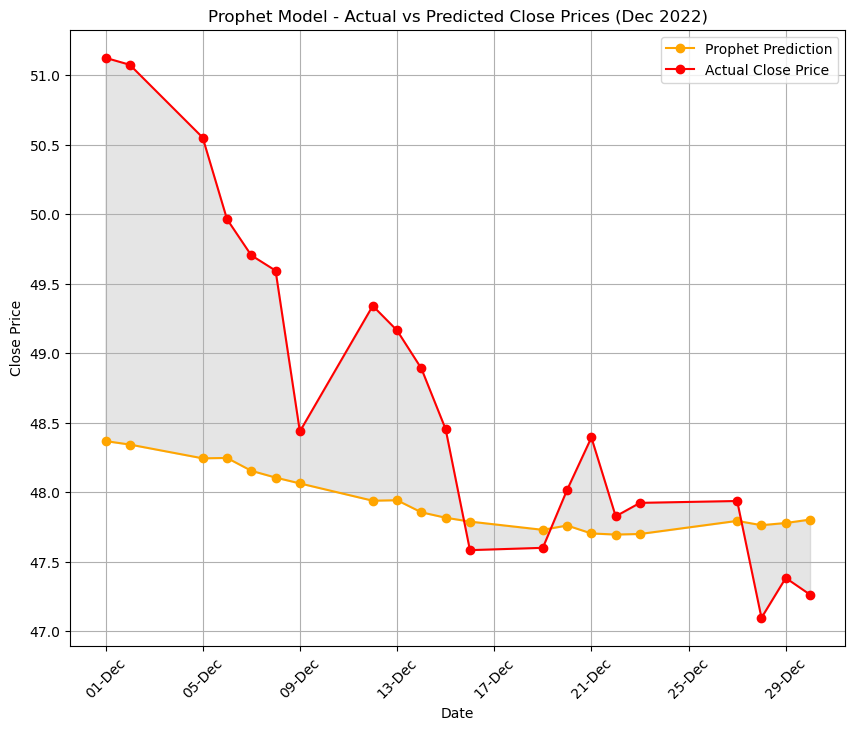

In [46]:
# Plot Prophet Predictions for December 2022
plt.figure(figsize=(10, 8))
plt.plot(prophet_predictions.index, prophet_predictions['yhat'], label='Prophet Prediction', color='orange', marker='o')
plt.plot(december_dates, data['Close'][december_mask], label='Actual Close Price', color='red', marker='o')

plt.title('Prophet Model - Actual vs Predicted Close Prices (Dec 2022)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.fill_between(prophet_predictions.index, data['Close'][december_mask], prophet_predictions['yhat'], color='gray', alpha=0.2)
plt.legend()
plt.grid(True)
plt.show()


# Calculate Error Metrics

In [47]:
# Define function to calculate error metrics
def evaluate_model(y_actual, y_pred, model_name):
    mae = mean_absolute_error(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)

    print(f"🔹 {model_name} Performance Metrics:")
    print(f"   📍 Mean Absolute Error (MAE): {mae:.4f}")
    print(f"   📍 Mean Squared Error (MSE): {mse:.4f}")

# Filter actual values for December 2022
y_actual_december = data['Close'][december_mask]

# Evaluate each model
evaluate_model(y_actual_december, predicted_december.flatten(), "LSTM")
evaluate_model(y_actual_december, arima_forecast, "ARIMA")
evaluate_model(y_actual_december, prophet_predictions['yhat'], "Prophet")


🔹 LSTM Performance Metrics:
   📍 Mean Absolute Error (MAE): 0.5384
   📍 Mean Squared Error (MSE): 0.3958
🔹 ARIMA Performance Metrics:
   📍 Mean Absolute Error (MAE): 0.3981
   📍 Mean Squared Error (MSE): 0.2530
🔹 Prophet Performance Metrics:
   📍 Mean Absolute Error (MAE): 0.9807
   📍 Mean Squared Error (MSE): 1.6469


# Comparison of LSTM, ARIMA & Prophet with Actual Close Prices

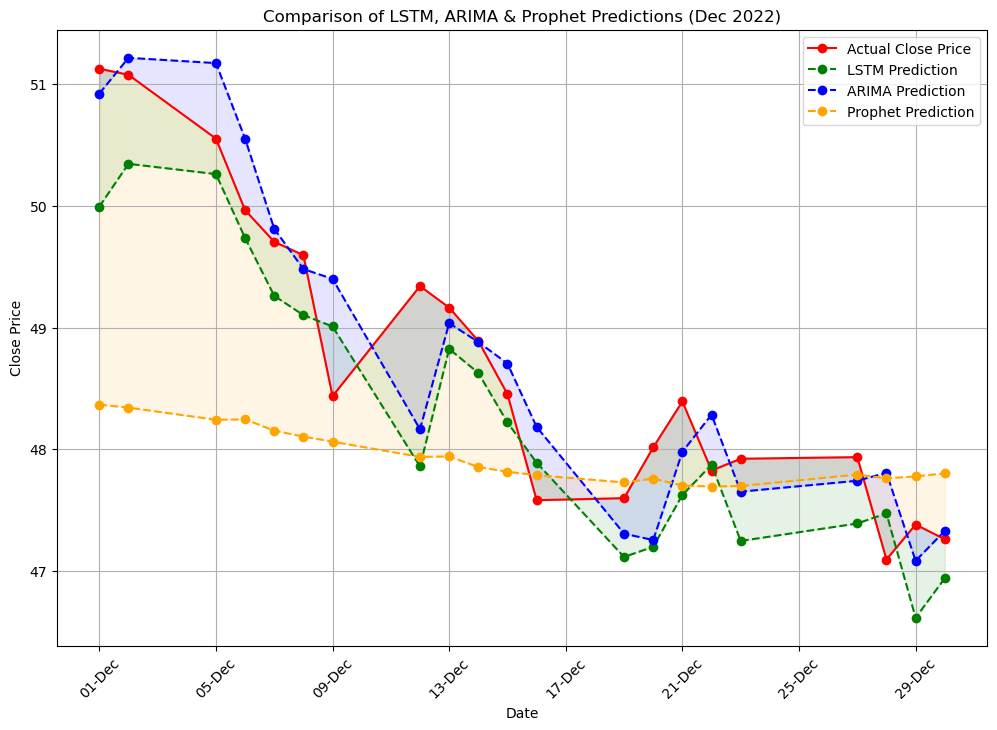

In [48]:
# Plot comparison of LSTM, ARIMA, and Prophet models for December 2022
plt.figure(figsize=(12, 8))

# Plot actual close prices
plt.plot(december_dates, data['Close'][december_mask], label='Actual Close Price', color='red', marker='o')

# Plot LSTM predictions
plt.plot(december_dates, predicted_december, label='LSTM Prediction', color='green', linestyle='dashed', marker='o')

# Plot ARIMA predictions
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Prediction', color='blue', linestyle='dashed', marker='o')

# Plot Prophet predictions
plt.plot(prophet_predictions.index, prophet_predictions['yhat'], label='Prophet Prediction', color='orange', linestyle='dashed', marker='o')

# Formatting the plot
plt.title('Comparison of LSTM, ARIMA & Prophet Predictions (Dec 2022)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.fill_between(december_dates, data['Close'][december_mask], predicted_december.flatten(), color='green', alpha=0.1)
plt.fill_between(arima_forecast.index, data['Close'][december_mask], arima_forecast, color='blue', alpha=0.1)
plt.fill_between(prophet_predictions.index, data['Close'][december_mask], prophet_predictions['yhat'], color='orange', alpha=0.1)
plt.legend()
plt.grid(True)
plt.show()
